# Table of contents

1. **Minimal approach:** how to run the code to read the DFT data, define the optimal model, and calculate the model coefficients.
2. **Plot results:** how to read the code results and plot the bands.
3. **Verify set alpha:** alternative code to verify if the selection is correct.
4. **Verify convergence:** check how the coefficients change with the number of remote bands.

# Minimal approach

In this first section we run the minimal code as shown in the paper. 

**How to select set alpha?**

Here we avoid plotting figures to keep the code simple. So, to properly identify the set A (alpha), the user must plot the bands separatelly (via xmgrace, for instance) and identify the index of the relevant bands.

Alternativelly, the user can replace *step 3* with a more elaborated code shown in the section **Verify set alpha** below.

In [1]:
import numpy as np
import pydft2kp as dft2kp

In [2]:
%%capture
# avoid unecessary output from the irrep package

# step 1: read DFT data
kp = dft2kp.irrep(dftdir='Bi2Se2Te',
                  outdir='outdir',
                  prefix='BiSeTe',
                  kpt=31,
                  kname='GM')

# step 2: read or calculate matrix elements of p
kp.get_p_matrices(qekp='kp.dat')

In [3]:
# step 3: define the set alpha
#         applies fold down via Löwdin
setA = np.arange(74,80)
kp.define_set_A(setA)

Space group  166 : R-3m
Group of the k-vector: <code not ready>
Verifying set A: [74 75 76 77 78 79]
Band indices: [74, 75] Irreps: (-GM6)(-GM7) Degeneracy: 2
Band indices: [76, 77] Irreps: (-GM8) Degeneracy: 2
Band indices: [78, 79] Irreps: (-GM9) Degeneracy: 2


In [32]:
# step 4: builds optimal model with qsymm
# s0, sx, sy, sz: Pauli matrices
from pydft2kp.constants import s0, sx, sy, sz
from scipy.linalg import expm

# build symmetry operations of D3d = {Inv, C2x, C3z}
# consider also time-reversal

# Inversion:
U = np.zeros((6,6), dtype=complex)
# (-GM8)(-GM9) both 2D irreps
orb  = +sz
spin = +s0
# (-GM6)+(-GM7) both 1D irreps (use characters)
U[0:4, 0:4] = np.kron(spin, orb)
U[4,4] = U[5,5] = -1.0
# total
Inv = dft2kp.inversion(3, U)

# C2x:
U = np.zeros((6,6), dtype=complex)
# (-GM8)(-GM9) both 2D irreps
orb  = +sz
spin = -1j*sx
# (-GM6)+(-GM7) both 1D irreps (use characters)
U = np.zeros((6,6), dtype=complex)
U[0:4, 0:4] = np.kron(spin, orb)
U[4,4] = +1.0j
U[5,5] = -1.0j
# total
C2x = dft2kp.rotation(1/2, [1,0,0], U=U)

# C3z:
U = np.zeros((6,6), dtype=complex)
# (-GM8)(-GM9) both 2D irreps
phi = (np.pi)/3
orb = +s0
spin = np.array([[np.exp(-1j*phi), 0],[0, np.exp(+1j*phi)]])
# (-GM6)+(-GM7) both 1D irreps (use characters)
U = np.zeros((6,6), dtype=complex)
U[0:4, 0:4] = np.kron(spin, orb)
U[4,4] = -1.0
U[5,5] = -1.0
# total
C3z = dft2kp.rotation(1/3, [0,0,1], U=U)

# TRS:
U = np.zeros((6,6), dtype=complex)
# (-GM8)(-GM9) both 2D irreps
orb = +s0
spin = +1j*sy
# (-GM6)+(-GM7) both 1D irreps (use characters)
U = np.zeros((6,6), dtype=complex)
U[0:4, 0:4] = np.kron(spin, orb)
U[4:6,4:6] = +1j*sy
# total
TRS = dft2kp.time_reversal(3, U=U)

symms = [Inv, C2x, C3z, TRS]
qs = dft2kp.qsymm(symms, dim=3, total_power=2, prettify=True, print_model=True, summed=True);

Matrix([
[c0 + c12*k_x**2 + c12*k_y**2 + c9*k_z**2,                                                                                                                                         I*c6*k_z,                                        0,                                                                                                                               I*c4*k_x + c4*k_y,                                                                                                           c3*k_x + I*c3*k_y + I*c5*k_x - c5*k_y,                                                                                                           -c3*k_x - I*c3*k_y + I*c5*k_x - c5*k_y],
[                               -I*c6*k_z,                                                                                                        c1 + c10*k_z**2 + c13*k_x**2 + c13*k_y**2,                        I*c4*k_x + c4*k_y,                                                                                             

In [33]:
# step 5: calculate the representation matrices for each symmetry operation
kp.get_symm_matrices()
# (optional): adds anti-unitary symmetry
kp.add_antiunitary_symm(TRS, np.array([0,0,0]))

# step 6: calculates and applies the transformation U
optimal = dft2kp.basis_transform(qs, kp)

# step 7: print results
optimal.print_report(sigdigits=3)

cn      a.u. (Ry, a0)    with (eV, nm)  units    k powers
----  ---------------  ---------------  -------  ----------
c0           -0.015           -0.204    eV       0
c1            0.00748          0.102    eV       0
c2           -0.0215          -0.293    eV       0
c3           -0.337           -0.243    eV.nm    x,y
c4           -0.41            -0.295    eV.nm    x,y
c5            0.0252           0.0181   eV.nm    x,y
c6           -0.126           -0.091    eV.nm    z
c7           -1.79            -0.0682   eV.nm²   xz,yz
c8            1.24             0.0472   eV.nm²   xz,yz
c9            2.3              0.0875   eV.nm²   zz
c10          -0.273           -0.0104   eV.nm²   zz
c11          -0.0636          -0.00242  eV.nm²   zz
c12           3.9              0.149    eV.nm²   xx,yy
c13          -2.74            -0.104    eV.nm²   xx,yy
c14           0.767            0.0292   eV.nm²   xx,xy,yy
c15          -1.79            -0.0682   eV.nm²   xx,yy
c16          -0.698           

# Checking traces

In [34]:
for i in range(len(qs.symm_pg)):
    print(f'({i})', qs.symm_pg[i], f'trace: {np.round(np.trace(qs.symms[i].U),1)}')

(0) ['I', 0, [0, 0, 1.0]] trace: (-2+0j)
(1) ['R', 180, [1.0, 0.0, 0.0]] trace: 0j
(2) ['R', 120, [0.0, 0.0, 1.0]] trace: 0j
(3) ['TT', 180, []] trace: 0j


In [35]:
generators = [6, 4, 1]
for i in generators: #range(len(kp.symm_pg)):
    print(f'({i})', kp.symm_pg[i], f'trace: {np.round(np.trace(kp.GammaDFT[i]), 1)}')
print('(TRS)', 'TRS', f'trace: {np.round(np.trace(kp.antiU[0][1]), 1)}')

(6) ['I', 0, [0, 0, 1]] trace: (-2+0j)
(4) ['R', 180, [1.0, 0.0, 0.0]] trace: (-0-0j)
(1) ['R', 120, [-0.0, -0.0, 1.0]] trace: (-0+0j)
(TRS) TRS trace: 0j


# Plot results

Once the model is complete, we can plot the bands.

Here the `qe_plotter(...)` is a helper to read the DFT bands in gnuplot format and organize the data to be plotted in python. It provides

- a helper routine `set_labels_and_limits(...)` to fix plot labels and k axis
- kdist: 1D array for the axis points properly spaced
- k3D: list of (kx,ky,kz) for each point in kdist

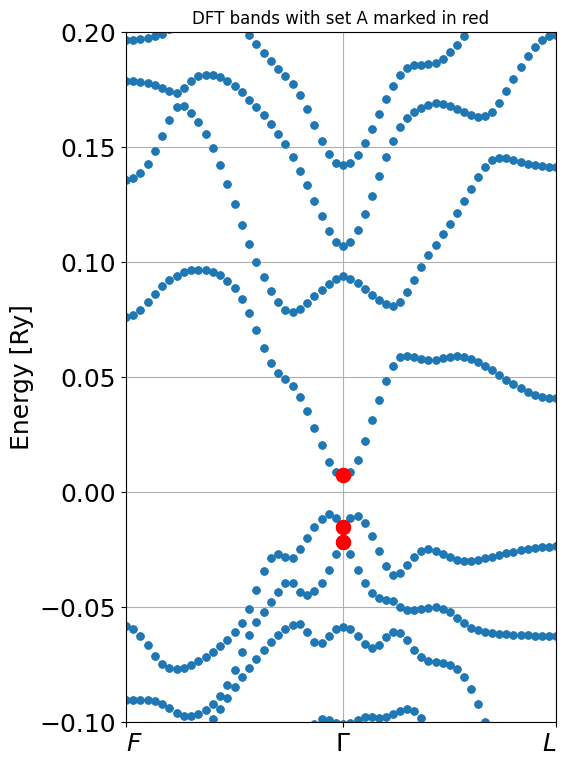

In [36]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})

# kpath as run in the bands calculation of QE
kpath = [[    30,          30,      1], 
         [R'$F$', R'$\Gamma$', R'$L$']]

# init plotter
bands = dft2kp.qe_plotter(kp, 'bands.gnu', kpath)

plt.figure(figsize=(6,8))
plt.title('DFT bands with set A marked in red', fontsize=12)
plt.plot(bands.kdist, bands.bands, 'o', ms=5, c='C0') # DFT
# ----------------------
# Emphasize set A in red
plt.scatter([0]*len(setA), bands.en_at_k[setA], c='red', s=100, zorder=10)
# ----------------------
bands.set_labels_and_limits(ax=plt.gca(), ymin=-0.1, ymax=0.2)
plt.grid()
plt.tight_layout()
plt.show()

In [37]:
# crude and optimal models as H(kx,ky,kz)

# build crude model with all bands
H_crude_full = kp.build_H_of_k(all_bands=True)
# build crude model folded into set A
H_crude_setA = kp.build_H_of_k(all_bands=False)

# the optimal model for set was already computed
# in step 6 above: optimal.Heff

# compute the eigenenergies as a function k for the path used in QE's data
Efull = np.array([np.linalg.eigvalsh(H_crude_full(*kvec)) for kvec in bands.k3D])
EsetA = np.array([np.linalg.eigvalsh(H_crude_setA(*kvec)) for kvec in bands.k3D])
Ek = np.array([np.linalg.eigvalsh(optimal.Heff(*kvec)) for kvec in bands.k3D])

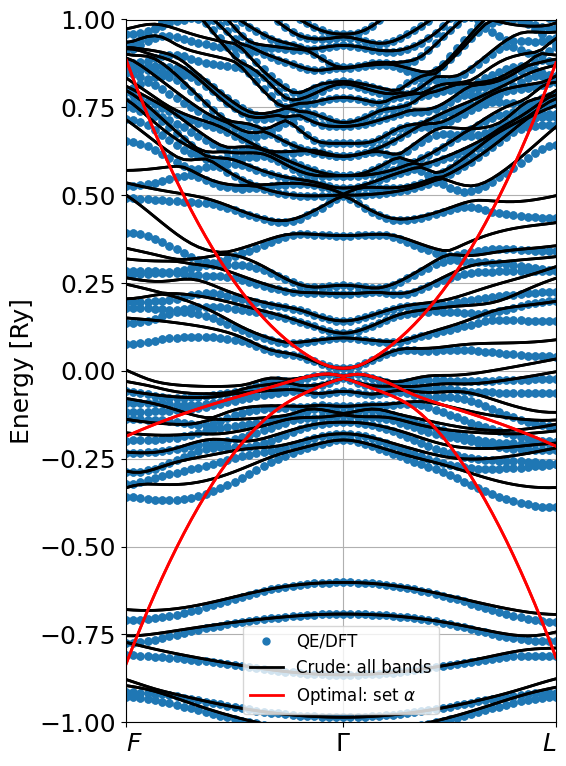

In [38]:
plt.figure(figsize=(6,8))
pdft   = plt.plot(bands.kdist, bands.bands, 'o', c='C0', ms=5) 
pcrude = plt.plot(bands.kdist, Efull, c='black', lw=2)
poptim = plt.plot(bands.kdist, Ek, c='red', lw=2)
# set legends for single lines
pdft[0].set_label('QE/DFT')
pcrude[0].set_label('Crude: all bands')
poptim[0].set_label(r'Optimal: set $\alpha$')
plt.legend(fontsize=12)
bands.set_labels_and_limits(ax=plt.gca(), ymin=-1, ymax=1)
plt.grid()

plt.tight_layout()
basename = 'Figures/' + kp.dftdir.replace('/', '')
plt.savefig(basename + '.svg')
plt.savefig(basename + '.png')
plt.show()

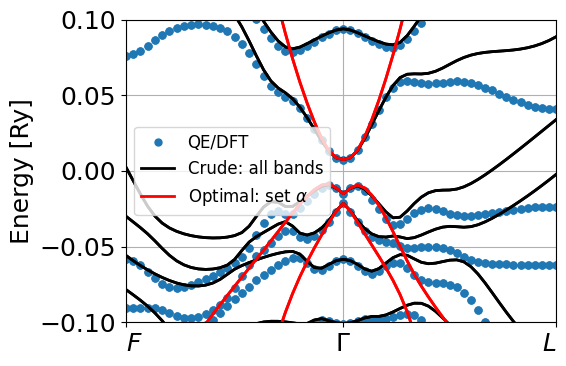

In [39]:
##############################################################
# ZOOM IN
##############################################################

plt.figure(figsize=(6,4))
pdft   = plt.plot(bands.kdist, bands.bands, 'o', c='C0', ms=5) 
pcrude = plt.plot(bands.kdist, Efull, c='black', lw=2)
poptim = plt.plot(bands.kdist, Ek, c='red', lw=2)
# set legends for single lines
pdft[0].set_label('QE/DFT')
pcrude[0].set_label('Crude: all bands')
poptim[0].set_label(r'Optimal: set $\alpha$')
plt.legend(fontsize=12)
bands.set_labels_and_limits(ax=plt.gca(), ymin=-0.1, ymax=0.1)#, xmin=-3*dft2kp.a0, xmax=3*dft2kp.a0)
plt.grid()

plt.tight_layout()
basename = 'Figures/' + kp.dftdir.replace('/', '')
plt.savefig(basename + '-zoom.svg')
plt.savefig(basename + '-zoom.png')
plt.show()

# Verify convergence

To verify the convergence of the parameter as a function of the number of bands, one can redo the folding down with a reduced number of remote bands and plot how the coefficients change as a function of the number of remote bands.

In [40]:
nbands = len(kp.energies)
NBs = np.arange(0, nbands - setA[-1], 1)
cns = []
for NB in NBs:
    # redo fold down using only NB remote bands
    kp.fold_down_H(NB=NB)
    # identify and store list of coefficients
    cns += [list(optimal.getHeff(qs, kp)[0])]
cns = np.array(cns)

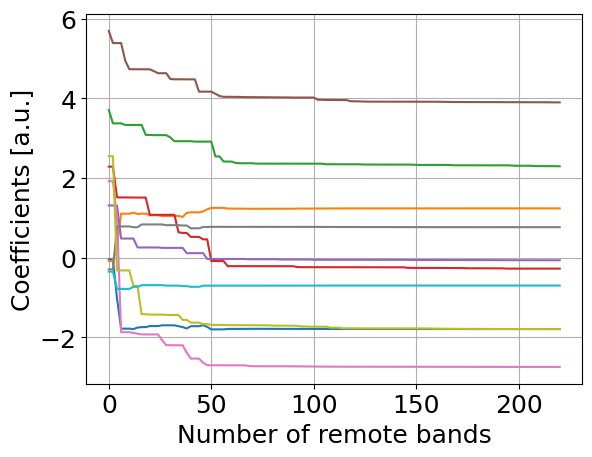

In [41]:
for n in range(cns.shape[1]):
    # only k² or larger powers depend on number of remote bands
    if set(optimal.keys[n]) & set([0, 'x','y','z']):
        continue
    plt.plot(NBs, cns[:,n], label=optimal.keys[n])
# plt.legend(fontsize=10)
plt.xlabel('Number of remote bands')
plt.ylabel(r'Coefficients [a.u.]')
plt.grid()
plt.show()